# Fun with language modelling

Если вы пропустили лекцию, то посмотрите слайды к ней — они где-то есть. Также полезно почитать:

* [Unreasonable effectiveness of RNN](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) (Andrej Karpathy)
* [Официальный пример от PyTorch](https://github.com/pytorch/examples/tree/master/word_language_model)

Рекомендуется заранее всё прочитать, чтобы понять, что от вас хотят. При желании, можете переписать всё так, как подсказывает ваше сердце.

---

In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Препроцессинг (3 балла)

Возьмите какие-нибудь сырые данные. Википедия, «Гарри Поттер», «Игра Престолов», тексты Монеточки, твиты Тинькова — что угодно.

Для простоты будем делать char-level модель. Выкиньте из текстов все ненужные символы (можете оставить только алфавит и, пунктуацию). Сопоставьте всем различным символам свой номер. Удобно это хранить просто в питоновском словаре (`char2idx`). Для генерации вам потребуется ещё и обратный словарь (`idx2char`). Вы что-то такое должны были писать на вступительной — можете просто переиспользовать код оттуда.

Заранее зарезервируйте айдишники под служебные символы: `<START>`, `<END>`, `<PAD>`, `<UNK>`.

Клёво будет написать отдельный класс, который делает токенизацию и детокенизацию.

In [3]:
real_man = '/content/drive/MyDrive/Zhirinovsky.txt' # сборник цитат великого и неподражаемого Владимира Вольфовича
len(open(real_man).readlines())

2253

In [4]:
class Vocab:
    def __init__(self, data):
        self.char2idx = {}
        self.idx2char = {}
        idx = 0
        for i in data:
            for j in i:
                if j not in self.char2idx.keys():
                    self.char2idx[j] = idx
                    self.idx2char[idx] = j
                    idx += 1 
        idx += 1
        for c in ['<START>', '<UNK>', '<PAD>', '<EOS>']:
            self.char2idx[c] = idx
            self.idx2char[idx] = c
            idx += 1
        
        
    
    def tokenize(self, sequence):
        # выполните какой-то базовый препроцессинг
        # например, оставьте только алфавит и пунктуацию
        return [self.char2idx[char] for char in sequence]
    
    def detokenize(self, sequence):
        return ''.join([self.idx2char[idx] for idx in sequence])
    
    def __len__(self):
        return len(self.char2idx) + 1 # 0, 1, 2, ...

In [5]:
class TextDataset:
    
    def __init__(self, data_path):
        # обучите вокаб
        
        self.min_len = 40  # предложения с меньшим количеством символов не будут рассматриваться
        self.max_len = 150 # предложения с большим количеством символов будут обрезаться

        # разделите данные на отдельные сэмплы для обучения
        # (просто список из сырых строк)
        self.data = [line.lstrip()[6:-8].lower() for line in open(data_path) if (line.lstrip().startswith('<text>')\
                                                                         and self.min_len < len(line.lstrip()[6:-8]) < self.max_len - 1)]
        self.vocab = Vocab(self.data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        sample = self.vocab.tokenize(sample)
        sample.insert(0, self.vocab.char2idx['<START>'])
        sample.insert(-1, self.vocab.char2idx['<EOS>'])
        while len(sample) < self.max_len:
            sample.append(self.vocab.char2idx['<PAD>'])
        target = sample[1:]
        target.append(self.vocab.char2idx['<EOS>'])
        sample = torch.tensor(sample, dtype=torch.long)
        target = torch.tensor(target, dtype=torch.long)
        return sample, target

Если у вас какой-то большой массив текста (скажем, статьи Википедии), вы можете просто нарезать из него кусочки фиксированной длины и так их подавать в модель.

Если же вы хотите приключений, то можно разбить этот текст на предложения (`nltk.sent_tokenize`), и тогда все примеры будут разной длины. По соображениям производительности, вы не хотите использовать самые длинные и самые короткие сэмплы, поэтому имеет смысл обрезать их по длине.

Разобьём на обучение и валидацию:

In [6]:
dataset = TextDataset(real_man)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

In [7]:
dataset[1][0].size(), dataset[1][1].size()

(torch.Size([150]), torch.Size([150]))

## Модель (3 балла)

Примерно такое должно зайти:

* Эмбеддинг
* LSTM / GRU
* Линейный слой
* Softmax

In [8]:
class LM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout, tie_weights):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.encoder = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, vocab_size)
        self.drop = nn.Dropout(dropout)
        
        if tie_weights:
            # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
            # https://arxiv.org/abs/1608.05859
            assert hidden_dim == embedding_dim
            self.decoder.weight = self.encoder.weight

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.reshape(output.size(0)*output.size(1), output.size(2)))
        return decoded.reshape(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, batch_size):
        # начальный хидден должен быть нулевой
        # (либо хоть какой-то константный для всего обучения)
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim)

## Обучение

In [9]:
epochs = 500
lr = 1e-3
batch_size = 64

device = torch.device('cpu')

model = LM(
    vocab_size = len(dataset.vocab),
    embedding_dim = 128,
    hidden_dim = 128,
    num_layers = 1,
    dropout = 0.1,
    tie_weights = True
).to(device)

#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.1) #torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.NAdam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)

train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test = DataLoader(test_set, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [10]:
train_loss = []
test_loss = []
for e in range(epochs):
    mean_train = 0
    for x, y in train:
        model.train()
        
        model.zero_grad()
        
        # 0. Распакуйте данные на нужное устройство
        # 1. Инициилизируйте hidden
        hidden = model.init_hidden(len(x))
        # 2. Прогоните данные через модель, получите предсказания на каждом токене
        output, _ = model(x, hidden)
        output = output.view(-1, output.size()[-1])
        y = y.view(-1)
        loss = criterion(output, y)
        loss.backward()
        # 3. Посчитайте лосс (maxlen независимых классификаций) и сделайте backward()
        # 4. Клипните градиенты -- у RNN-ок с этим часто бывают проблемы
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
        # 5. Залоггируйте лосс куда-нибудь
        
        train_loss.append(loss.item())
        mean_train += loss.item()
        optimizer.step()
    
    for x, y in test:
        mean_test = 0
        with torch.no_grad():
            model.eval()
            hidden = model.init_hidden(len(x))
            output, _ = model(x, hidden)
            output = output.view(-1, output.size()[-1])
            y = y.view(-1)
            loss = criterion(output, y)
            test_loss.append(loss.item())
            mean_test += loss.item()
    print('Epoch : {} | Mean training loss : {:.3f} | Mean test loss : {:.3f}'.format(e, mean_train / len(train), mean_test / len(test)))
    if e % 50 == 0:
        lr_scheduler.step()
         # сдесь нужно сделать то же самое, только без backward

Epoch : 0 | Mean training loss : 6.131 | Mean test loss : 5.022
Epoch : 1 | Mean training loss : 5.268 | Mean test loss : 4.320
Epoch : 2 | Mean training loss : 4.672 | Mean test loss : 3.765
Epoch : 3 | Mean training loss : 4.133 | Mean test loss : 3.302
Epoch : 4 | Mean training loss : 3.703 | Mean test loss : 2.926
Epoch : 5 | Mean training loss : 3.343 | Mean test loss : 2.662
Epoch : 6 | Mean training loss : 3.131 | Mean test loss : 2.395
Epoch : 7 | Mean training loss : 2.904 | Mean test loss : 2.258
Epoch : 8 | Mean training loss : 2.720 | Mean test loss : 2.133
Epoch : 9 | Mean training loss : 2.617 | Mean test loss : 2.046
Epoch : 10 | Mean training loss : 2.553 | Mean test loss : 1.978
Epoch : 11 | Mean training loss : 2.468 | Mean test loss : 1.904
Epoch : 12 | Mean training loss : 2.406 | Mean test loss : 1.894
Epoch : 13 | Mean training loss : 2.324 | Mean test loss : 1.835
Epoch : 14 | Mean training loss : 2.288 | Mean test loss : 1.833
Epoch : 15 | Mean training loss : 2

KeyboardInterrupt: ignored

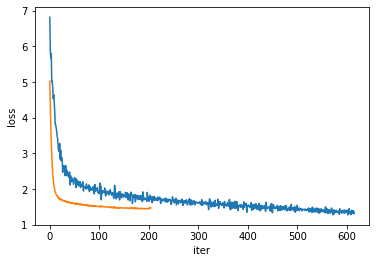

In [12]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

## Спеллчекер (3 балла)

Из языковой модели можно сделать простенький спеллчекер: можно визуализировать лоссы на каждом символе (либо какой-нибудь другой показатель неуверенности).

Бонус: можете усреднить перплексии по словам и выделять их, а не отдельные символы.

In [13]:
from IPython.core.display import display, HTML

def print_colored(sequence, intensities, delimeter=''):
    html = delimeter.join([
        f'<span style="background: rgb({255}, {255-x}, {255-x})">{c}</span>'
        for c, x in zip(sequence, intensities) 
    ])
    display(HTML(html))

print_colored('Налейте мне экспрессо'.split(), [0, 0, 100], ' ')

sequence = 'Эту домашку нужно сдать втечении двух недель'
intensities = [0]*len(sequence)
intensities[25] = 50
intensities[26] = 60
intensities[27] = 70
intensities[31] = 150
print_colored(sequence, intensities)

In [14]:
def spellcheck(sequence):
    with torch.no_grad():
        model.eval()
        string_seq = sequence
        # векторизуйте sequence; паддинги делать не нужно
        sequence = torch.tensor(dataset.vocab.tokenize(sequence.lower()), dtype=torch.long).view(1, -1)
        
        # прогоните модель и посчитайте лосс, но не усредняйте
        # с losses можно что-нибудь сделать для визуализации; например, в какую-нибудь степень возвести
        hidden = model.init_hidden(len(sequence))
        out, _ = model(sequence, hidden)
        losses = nn.CrossEntropyLoss(reduction='none')(out.view(-1, out.size()[-1]), sequence[0])
        print_colored(string_seq, losses**2)

In [15]:
sequences = ['В этом претложениии очен много очепяток.', 
             'Здесь появилась лишнняя буква.', 
             'В этом предложении все нормально.', 
             'Чтонибудь пишеться чериз дефис.', 
             'Слова нрпдзх не сущесдвует.']

for sequence in sequences:
    spellcheck(sequence)

## Генерация предложений (3 балла)

* Поддерживайте hidden state при генерации. Не пересчитывайте ничего больше одного раза.
* Прикрутите температуру: это когда при сэмплировании все логиты (то, что перед софтмаксом) делятся на какое-то число (по умолчанию 1, тогда ничего не меняется). Температура позволяет делать trade-off между разнообразием и правдоподобием (подробнее — см. блог Карпатого).
* Ваша реализация должна уметь принимать строку seed — то, с чего должно начинаться сгенерированная строка.

In [16]:
def sample(num_tokens, seed="", temperature=1.0):
    model.eval()
    #print('hello ', seed)
    input = torch.LongTensor(dataset.vocab.tokenize(seed.lower())).view(1, -1)
    hidden = model.init_hidden(len(input))

    continuation = ''
    
    for _ in range(num_tokens):
        output, hidden = model(input, hidden)
        
        token_probas = output.squeeze().div(temperature).exp().cpu()
        token = torch.multinomial(token_probas, 1)[0]

        continuation += dataset.vocab.idx2char[token.item()]# допишите соответствующий символ

        input = seed + continuation
        input = torch.LongTensor(dataset.vocab.tokenize(input.lower())).view(1, -1) # обновите input
    
    return continuation

In [25]:
beginnings = ['Шел медведь по лесу', 
              'Встретились англичанин, американец и русский. Англичанин говорит:',
              'Так вот, однажды качки решили делать ремонт',
              'Поручик Ржевский был',
              'Идёт Будда с учениками по дороге',
              'Мюллер: Штирлиц, где вы были в 1930 году?',
              'Засылают к нам американцы шпиона под видом студента',
              'Подъезжает электричка к Долгопе:']

for beginning in beginnings:
    try:
        print(f'{beginning}... {sample(10, beginning)}')
        print()
    except:
        print('Странная ошибка, символа <, которого нигде нет\n')

Странная ошибка, символа <, которого нигде нет

Встретились англичанин, американец и русский. Англичанин говорит:... аыи    осс

Так вот, однажды качки решили делать ремонт... р,ыые  оас

Поручик Ржевский был... уеиеаоарар

Идёт Будда с учениками по дороге... т  ззсмчрт

Мюллер: Штирлиц, где вы были в 1930 году?... уееи  еыон

Засылают к нам американцы шпиона под видом студента... ы ааргяуг 

Подъезжает электричка к Долгопе:... ррруаллеее



In [ ]:
#надо бы допилить . <eos>